<a href="https://colab.research.google.com/github/vbeohar/w207_spring2020_section4_aav/blob/master/Final_Project_W207_Andrew_Dively_Vaibhav_Beohar_Andrew_Fogarty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

We are interested in exploring various factors that affect Airbnb prices across various major metropolitan areas in the United States. Our data, acquired from Kaggle, has various different key data points on Airbnb listings such as amenities, GPS coordinates, and home information. We intend to run various different model types to create a model that excells in predicting on unseen data. We will first start with basic models, such as linear regression, and then move onto Deep Learning with Keras and advanced linear modeling using XGBoost and SVMs. We then plan to tune our models using GridSearchCV or Hyperopt.

In [0]:
# packages
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVR, SVR
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
sns.set_context('notebook')
sns.set_style('white')

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.linear_model import Ridge
from sklearn import linear_model
from scipy import stats
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from functools import partial
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RepeatedKFold
from prettytable import PrettyTable
np.random.seed(0)

from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error 

from sklearn.feature_selection import SelectFromModel
import statsmodels.stats.api as sms


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
# functions and miscellaneous
mse = make_scorer(metrics.mean_squared_error)

# functions
# confidence interval
def confidence_interval(confidence_level, predicted_y, y_test):
    confidence = confidence_level
    squared_errors = (predicted_y - y_test) ** 2
    return np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                             loc = squared_errors.mean(),
                             scale = stats.sem(squared_errors)))

# result storage
model_name = []
RMSE = []
CI = []
cross_val_mean = []

# New Section

# Load Data and Feature Engineering

In [0]:
def load_data():
    # load csv
    df = pd.read_csv('https://www.dropbox.com/s/nkawjgx3ynrv9vw/train_cleaned.csv?dl=1')

    # create dummies for some variables that should have them
    df2 = pd.get_dummies(data =df, columns = ['city', 'room_type', 'property_type'])

    # grab the new dummies
    df2 = df2.iloc[:, 43::]

    #Remove spaces from column headers for later graphical descriptions and model outputs
    df.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)
    df2.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)

    # concat into CSV DF
    df = pd.concat([df, df2], axis = 1)

    # remove string vars
    df = df.select_dtypes(exclude=[np.object])

    # drop na
    df = df.dropna(axis = 0)
    return df

df = load_data()
X_cols = list(df.columns)
X_cols = np.delete(X_cols, 1, None)
print('Feature engineered set of columns\n', len(X_cols))

Feature engineered set of columns
 75


In [0]:
# prepare data set
def prepare_data(df):
    # prepare X, y
    y = df['log_price'].values
    X = df.drop(['log_price'], axis = 1).values

    # shuffle data
    shuffle = np.random.permutation(np.arange(X.shape[0]))
    X, y = X[shuffle], y[shuffle]

    # split data
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, random_state = 42)
    X_train, X_dev, y_train, y_dev = train_test_split(X_train_full, y_train_full, random_state = 42)

    # scale data
    scaler = StandardScaler()
    X_train_full = scaler.fit_transform(X_train_full)
    X_train = scaler.transform(X_train)
    X_dev = scaler.transform(X_dev)
    X_test = scaler.transform(X_test)

    return X_train_full, X_test, y_train_full, y_test, X_train, X_dev, y_train, y_dev

X_train_full, X_test, y_train_full, y_test, X_train, X_dev, y_train, y_dev = prepare_data(df)

print('X_train_full:', X_train_full.shape)
print('y_train_full:', y_train_full.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_dev:', X_dev.shape)
print('y_dev', y_dev.shape)
print('X_cols', len(X_cols))


X_train_full: (40146, 75)
y_train_full: (40146,)
X_test: (13382, 75)
y_test: (13382,)
X_train: (30109, 75)
y_train: (30109,)
X_dev: (10037, 75)
y_dev (10037,)
X_cols 75


# Feature Engineering Discussion


In [0]:
df.head()

,id,log_price,internet,air_conditioning,breakfast,parking,kitchen,pool,pets_allowed,checkin_24,tv,laundry,accommodates,bathrooms,flexible,moderate,strict,cleaning_fee,host_has_profile_pic,host_identity_verified,instant_bookable,latitude,longitude,miles_city_center,cc_latitude,cc_longitude,number_of_reviews,review_scores_rating,has_thumbnail,zipcode,bedrooms,beds,city_Boston,city_Chicago,city_DC,city_LA,city_NYC,city_SF,room_type_Entire_home/apt,room_type_Private_room,room_type_Shared_room,property_type_Apartment,property_type_Bed_&_Breakfast,property_type_Boat,property_type_Boutique_hotel,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Casa_particular,property_type_Castle,property_type_Cave,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_Earth_House,property_type_Guest_suite,property_type_Guesthouse,property_type_Hostel,property_type_House,property_type_Hut,property_type_In-law,property_type_Island,property_type_Lighthouse,property_type_Loft,property_type_Other,property_type_Parking_Space,property_type_Serviced_apartment,property_type_Tent,property_type_Timeshare,property_type_Tipi,property_type_Townhouse,property_type_Train,property_type_Treehouse,property_type_Vacation_home,property_type_Villa,property_type_Yurt
0,6901257,5.010635,1,1,0,0,1,0,0,0,0,0,3,1.0,0,0,1,1,1.0,1.0,0,40.696524,-73.991617,2.708,40.712743,-74.013380,2,100.0,1,11201.0,1.0,1.0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,6304928,5.129899,1,1,0,0,1,0,0,0,0,1,7,1.0,0,0,1,1,1.0,0.0,1,40.766115,-73.989040,5.882,40.712743,-74.013380,6,93.0,1,10019.0,3.0,3.0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,7919400,4.976734,1,1,1,0,1,0,0,0,1,0,5,1.0,0,1,0,1,1.0,1.0,1,40.808110,-73.943756,11.837,40.712743,-74.013380,10,92.0,1,10027.0,1.0,3.0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3808709,4.744932,1,1,0,0,1,0,0,0,1,0,2,1.0,0,1,0,1,1.0,1.0,1,38.925627,-77.034596,2.800,38.897743,-77.036530,4,40.0,0,20009.0,0.0,1.0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,12422935,4.442651,1,0,0,0,0,0,0,0,1,0,2,1.0,0,0,1,1,1.0,1.0,1,37.753164,-122.429526,4.998,37.795211,-122.402779,3,100.0,1,94131.0,1.0,1.0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Data Cleaning**

First, various errors in the dataset had to be corrected. All zip codes were converted to a standard 5 digit format.

**Listing Amenities**

Originially, this was listed in a long line of text for every single amenity included in the property. We researched Top 10 amenities that guests are interested in and created dummy variables for each amenitiy, such as Pool, Parking, Kitchen, etc.

**Categorical Variables**

For categorical variables, such as the cancellation policy (flexible, moderate, strict). We converted these to dummy variables to make it easier to quantify.

**Distance from City Center**

We gathered the GPS coordinates for the city centers in each of our 5 cities, and used a complex formula to calculate the distance between two GPS coordinates around the curvature of the earth. We believe this is a valuable feature as many tourists prefer to be closer to the city center. 

**Property Type**

We also created dummy variables for each property type as this would help us understand pricing for different property types.

# EDA Discussion

### Plotting dependent variable

Text(0, 0.5, '# of Listings')

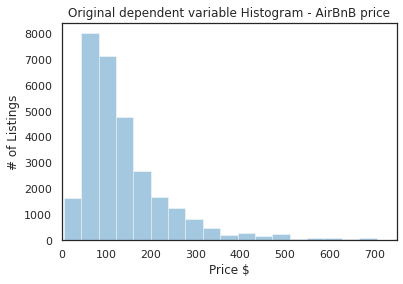

In [0]:
sns.distplot(np.exp(y_train), kde=False)
plt.title('Original dependent variable Histogram - AirBnB price')
plt.xlim([0,750])
plt.xlabel("Price $")
plt.ylabel("# of Listings")

Text(0, 0.5, '# of Listings')

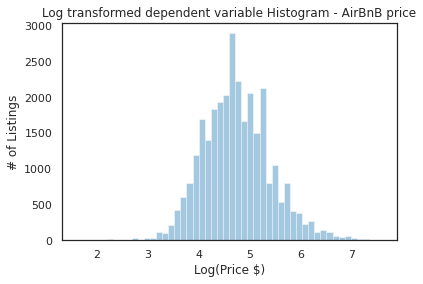

In [0]:
sns.distplot(y_train, kde=False)
plt.title('Log transformed dependent variable Histogram - AirBnB price')
plt.xlabel('Log(Price $)')
plt.ylabel('# of Listings')

### Nominal variables and their correlation to dependent variable

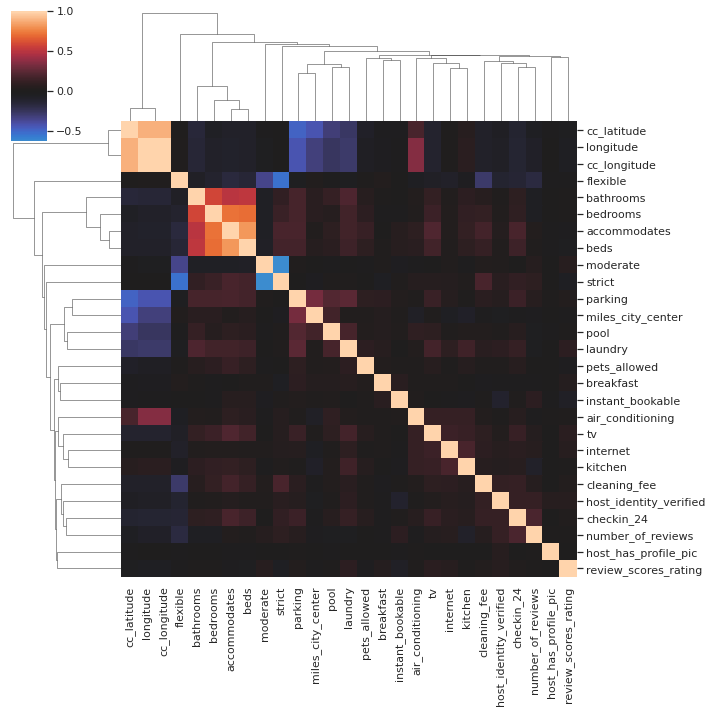

In [0]:
nominal = ['internet','air_conditioning','breakfast','parking','kitchen','pool','pets_allowed',
           'checkin_24','tv','laundry','accommodates','bathrooms','flexible','moderate','strict',
           'cleaning_fee','host_has_profile_pic','host_identity_verified','instant_bookable','longitude',
           'miles_city_center','cc_latitude','cc_longitude','number_of_reviews','review_scores_rating',
           'bedrooms','beds']

df_quant = df[nominal]

sns.clustermap(df_quant.corr(), center=0)

# Keras
In this section, we do the following on deep learning models:
1. Discovery: Find the best wide/deep typology through loop experiments
2. Initial Model: Select best typology and run it.
3. Optimization: Optimize best typology through hyperopt -- a hyperparameter optimization package
4. Testing: Train the optimized model on the full training data to generate a final RMSE against the test set.

## Keras: Part 1 - Discovery
To review our series of wide/deep neural network typology experiments, omitted here for brevity and length, please visit: https://colab.research.google.com/drive/1lapqjopjROlAuzJpQrKfAhtBNvTHRCmc?usp=sharing

## Keras: Part 2 - Initial Model
Our part 1 experiments suggests that we should use a deep learning model with approximately 3 hidden layers with 300 neurons each. We instantiate the model and examine its results in more detail below.

In [0]:
# We begin with 3 hidden layers @ 300 neurons

# build neural network
RegularizedDense = partial(keras.layers.Dense,
                           kernel_initializer="he_normal",
                           activation="elu")  

model = keras.models.Sequential([
    RegularizedDense(300, input_shape=[X_train.shape[1]]),
    RegularizedDense(300),
    RegularizedDense(300),                         
    keras.layers.Dense(1)
])

In [0]:
# create callbacks

# stop if no dev set progress detected after 5 epochs
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  restore_best_weights=True)

# create epoch-end checkpoints
checkpoint_cb = keras.callbacks.ModelCheckpoint('keras_model_cp.h5',
                                                save_best_only=True)

# create learning rate callback
lr_scheduler_plateau = keras.callbacks.ReduceLROnPlateau(factor=0.7,
                                                         patience=3)

In [0]:
# compile the model
model.compile(loss='mean_squared_error',  # regression
              optimizer=keras.optimizers.RMSprop(lr = 0.01, rho = 0.9))

# fit the model
history = model.fit(X_train, y_train,
                    batch_size=32,
                    verbose=2,
                    epochs=100,
                    validation_data=(X_dev, y_dev),
                    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler_plateau])

Epoch 1/100
941/941 - 4s - loss: 12.5744 - val_loss: 2.7044 - lr: 0.0100
Epoch 2/100
941/941 - 4s - loss: 3.9800 - val_loss: 1.5699 - lr: 0.0100
Epoch 3/100
941/941 - 4s - loss: 7.1888 - val_loss: 0.5407 - lr: 0.0100
Epoch 4/100
941/941 - 4s - loss: 4.9529 - val_loss: 1.2912 - lr: 0.0100
Epoch 5/100
941/941 - 4s - loss: 3.8230 - val_loss: 2.1604 - lr: 0.0100
Epoch 6/100
941/941 - 4s - loss: 4.2987 - val_loss: 588.1833 - lr: 0.0100
Epoch 7/100
941/941 - 4s - loss: 65.4064 - val_loss: 2.4438 - lr: 0.0070
Epoch 8/100
941/941 - 4s - loss: 2.0141 - val_loss: 3.9587 - lr: 0.0070
Epoch 9/100
941/941 - 4s - loss: 1.7037 - val_loss: 0.4851 - lr: 0.0070
Epoch 10/100
941/941 - 4s - loss: 2.2523 - val_loss: 1.9411 - lr: 0.0070
Epoch 11/100
941/941 - 4s - loss: 1.6583 - val_loss: 1.1365 - lr: 0.0070
Epoch 12/100
941/941 - 4s - loss: 2.8008 - val_loss: 0.7886 - lr: 0.0070
Epoch 13/100
941/941 - 4s - loss: 1.0154 - val_loss: 0.7502 - lr: 0.0049
Epoch 14/100
941/941 - 4s - loss: 1.0315 - val_loss: 0.5

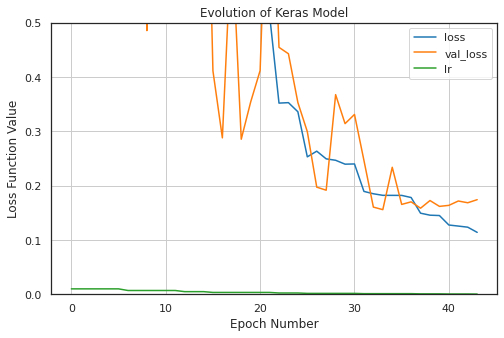

In [0]:
# plot results
pd.DataFrame(history.history).plot(figsize = (8, 5))
plt.grid(True)
plt.gca().set_ylim(0.0, 0.5)
plt.title("Evolution of Keras Model")
plt.ylabel("Loss Function Value")
plt.xlabel("Epoch Number")
plt.show()

In [0]:
# generate test set predictions
np.sqrt(model.evaluate(X_test, y_test))

419/419 [==============================] - 1s 1ms/step - loss: 0.1534


0.39159973600727416

We can see that our model starts to diverge and is overfitting slightly on the training data around 30 epochs. To solve this, we consider the incorporation of batch normalization and dropout, two regularizing techniques. 

## Keras: Part 3 - Optimization

The code for our `hyperas` optimization can be found here: https://colab.research.google.com/drive/1RlGRW5kwCAFrBr4-xtjLKE3R7f064_cm?usp=sharing

Our optimization tests ran for 1 hour\, resulting in the following specification: 

`Best performing model chosen hyper-parameters:
{'Dropout': 0.4182140362909876, 'Dropout_1': 0.47663695683601787, 'Dropout_2': 0.06874772122693129, 'RegularizedDense': 1, 'RegularizedDense_1': 2, 'RegularizedDense_2': 1, 'RegularizedDense_3': 2, 'batch_size': 0, 'optimizer': 3}`

## Keras: Part 4 - Testing

In this section, we train our optimized model on the full training data and evaluate it on the test set.

In [0]:
# load data
X_train_full, X_test, y_train_full, y_test, X_train, X_dev, y_train, y_dev = prepare_data(df)

# build neural network
RegularizedDense = partial(keras.layers.Dense,
                               kernel_initializer="he_normal",
                               use_bias=False)

model = keras.models.Sequential([
    RegularizedDense(300, input_shape=[X_train.shape[1]]),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('elu'),
    keras.layers.Dropout(rate=0.41),
    RegularizedDense(300),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('elu'),
    keras.layers.Dropout(rate=0.47),    
    RegularizedDense(350),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('elu'),
    keras.layers.Dropout(rate=0.06),                               
    keras.layers.Dense(1)
])

In [0]:
# compile the model
model.compile(loss='mean_squared_error',  # regression
              optimizer=keras.optimizers.Nadam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999))

# fit the model to full data
history = model.fit(X_train_full, y_train_full,
                    batch_size=32,
                    verbose=2,
                    epochs=100,
                    validation_data=(X_dev, y_dev),
                    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler_plateau])

Epoch 1/100
1255/1255 - 10s - loss: 1.1155 - val_loss: 0.7634 - lr: 0.0010
Epoch 2/100
1255/1255 - 10s - loss: 0.3361 - val_loss: 0.2286 - lr: 0.0010
Epoch 3/100
1255/1255 - 9s - loss: 0.2553 - val_loss: 0.1840 - lr: 0.0010
Epoch 4/100
1255/1255 - 9s - loss: 0.2221 - val_loss: 0.1627 - lr: 0.0010
Epoch 5/100
1255/1255 - 9s - loss: 0.2067 - val_loss: 0.1553 - lr: 0.0010
Epoch 6/100
1255/1255 - 9s - loss: 0.1975 - val_loss: 0.1593 - lr: 0.0010
Epoch 7/100
1255/1255 - 9s - loss: 0.1885 - val_loss: 0.1754 - lr: 0.0010
Epoch 8/100
1255/1255 - 9s - loss: 0.1837 - val_loss: 0.1563 - lr: 0.0010
Epoch 9/100
1255/1255 - 9s - loss: 0.1779 - val_loss: 0.1398 - lr: 7.0000e-04
Epoch 10/100
1255/1255 - 9s - loss: 0.1734 - val_loss: 0.1385 - lr: 7.0000e-04
Epoch 11/100
1255/1255 - 9s - loss: 0.1715 - val_loss: 0.1460 - lr: 7.0000e-04
Epoch 12/100
1255/1255 - 9s - loss: 0.1700 - val_loss: 0.1415 - lr: 7.0000e-04
Epoch 13/100
1255/1255 - 9s - loss: 0.1688 - val_loss: 0.1379 - lr: 7.0000e-04
Epoch 14/100

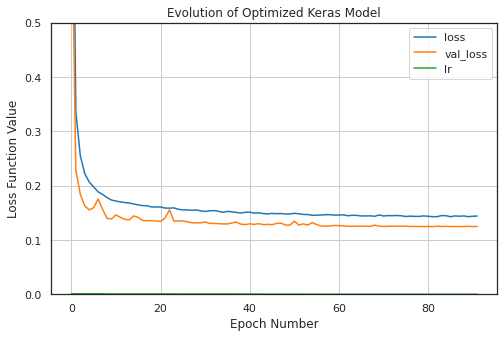

In [0]:
# plot results
pd.DataFrame(history.history).plot(figsize = (8, 5))
plt.grid(True)
plt.gca().set_ylim(0.0, 0.5)
plt.title("Evolution of Optimized Keras Model")
plt.ylabel("Loss Function Value")
plt.xlabel("Epoch Number")
plt.show()

In [0]:
# generate test set predictions - RMSE
keras_RMSE = np.round(np.sqrt(model.evaluate(X_test, y_test)), 3)
print('The RMSE for our Keras model is:', keras_RMSE)

419/419 [==============================] - 1s 2ms/step - loss: 0.1330
The RMSE for our Keras model is: 0.365


In [0]:
# get X, y for CV
def prepare_xy(df):
    load_data()
    # prepare X, y
    y = df['log_price'].values
    X = df.drop(['log_price'], axis = 1).values

    # shuffle data
    shuffle = np.random.permutation(np.arange(X.shape[0]))
    X, y = X[shuffle], y[shuffle]

    # scale data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    return X, y

X, y = prepare_xy(df)


# cross validation keras
def cross_val_model():
    model = keras.models.Sequential([
    RegularizedDense(300, input_shape=[X_train.shape[1]]),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('elu'),
    keras.layers.Dropout(rate=0.41),
    RegularizedDense(300),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('elu'),
    keras.layers.Dropout(rate=0.47),    
    RegularizedDense(350),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('elu'),
    keras.layers.Dropout(rate=0.06),                               
    keras.layers.Dense(1)])
  
    # compile the model
    model.compile(loss='mean_squared_error',  # regression
              optimizer=keras.optimizers.Nadam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999))
    return model

# cv
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
cvscores = []
for train, test in kfold.split(X, y):
  model = cross_val_model()
  model.fit(X[train], y[train], 
           epochs=100, 
           batch_size=32, 
           verbose=0)
  keras_cross_RMSE = np.round(np.sqrt(model.evaluate(X[test], y[test], verbose=0)), 3)
  scores = model.evaluate(X[test], y[test], verbose=0)
  cvscores.append(scores)

KeyboardInterrupt: ignored

In [0]:
# append results
model_name.append('Sequential Keras')
RMSE.append(keras_RMSE)
CI.append(0)
# CI.append(sms.DescrStatsW(keras_RMSE).tconfint_mean()) # throwing error
cross_val_mean.append(np.sqrt(np.mean(cvscores)))

# Baseline and Alternative Models

## Linear, Ridge, Lasso and SVM

In [0]:
# Linear Model
lm = LinearRegression() # instantiate lm
lm.fit(X_train_full, y_train_full); # fit lm
r2_lm = lm.score(X_train_full, y_train_full) # x, y

# generate predictions
predicted_y = lm.predict(X_test) # prediction

# metrics
lm_RMSE = mean_squared_error(y_test, predicted_y, squared = False)

# confidence interval for RMSE
lm_ci = confidence_interval(0.95, predicted_y, y_test)

# cross-val on dev data
scores = cross_val_score(lm, X_dev, y_dev, 
                         scoring="neg_mean_squared_error",  # expects utility fx 
                         cv=10) # 10 folds

rmse_scores = np.sqrt(-scores) # sqrt for RMSE

# append results
model_name.append('Linear Regression')
RMSE.append(lm_RMSE)
CI.append(lm_ci)
cross_val_mean.append(rmse_scores.mean())

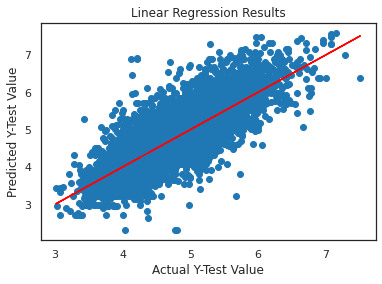

In [0]:
plt.scatter(predicted_y, y_test)
plt.xlabel("Actual Y-Test Value")
plt.ylabel("Predicted Y-Test Value")
plt.title("Linear Regression Results")
plt.plot(predicted_y, predicted_y, color='red')

In [0]:
# Linear Ridge Regression
ridge = Ridge(alpha = 1) # instantiate lm
ridge.fit(X_train, y_train); # fit lm
r2_ridge = ridge.score(X_train, y_train) # r2

# setup grid search params
params = [{'alpha' : np.random.uniform(100, 500, 100)}]

# grid search hyperparameter alpha
rnd_search_cv = RandomizedSearchCV(ridge, params, n_iter = 30, verbose = 0, cv = 3, scoring = mse, random_state = 42)

# validate search on dev data
rnd_search_cv.fit(X_dev, y_dev) # search over the dev data

rnd_search_cv.best_estimator_ # estimator that was chosen by the search
rnd_search_cv.best_score_ # mean cross-validated score of the best_estimator

# fit again on full data now with best estimator
final_model = rnd_search_cv.best_estimator_

final_model.fit(X_train_full, y_train_full); # fit lm on full data
r2_ridge = ridge.score(X_train_full, y_train_full) # r2

# generate predictions
predicted_y1 = ridge.predict(X_test) # prediction

# metrics
ridge_RMSE = mean_squared_error(y_test, predicted_y1, squared = False)

# confidence interval for RMSE
ridge_ci = confidence_interval(0.95, predicted_y1, y_test)

# cross-val predictive power on dev data
scores = cross_val_score(final_model, X_dev, y_dev,
                         scoring = "neg_mean_squared_error", # expects utility fx
                         cv = 10) # 10 folds

rmse_scores = np.sqrt(-scores) # sqrt for RMSE

# append results
model_name.append('Ridge Regression')
RMSE.append(ridge_RMSE)
CI.append(ridge_ci)
cross_val_mean.append(rmse_scores.mean())

In [0]:
# Linear Lasso Regression
lasso = linear_model.Lasso(alpha = 0.001)
lasso.fit(X_train, y_train); # fit lm
r2_lasso = lasso.score(X_train, y_train) # x, y

# setup grid search params
params = [{'alpha' : np.random.uniform(0.1, 500, 100)}]

# grid search hyperparameter alpha
rnd_search_cv = RandomizedSearchCV(lasso, params, n_iter = 30, verbose = 0, cv = 3, scoring = mse, random_state = 42)

# validate search on dev data
rnd_search_cv.fit(X_dev, y_dev) # search over the dev data

# fit again on full data now with best estimator
final_model = rnd_search_cv.best_estimator_
final_model.fit(X_train_full, y_train_full); # fit lasso on full data
r2_lasso = lasso.score(X_train_full, y_train_full) # r2

# generate predictions
predicted_y2 = lasso.predict(X_test) # prediction

# metrics
lasso_RMSE = mean_squared_error(y_test, predicted_y2, squared = False)

# confidence interval for RMSE
lasso_ci = confidence_interval(0.95, predicted_y2, y_test)

# cross-val predictive power on dev data
scores = cross_val_score(final_model, X_dev, y_dev,
                         scoring = "neg_mean_squared_error", # expects utility fx
                         cv = 10) # 10 folds

rmse_scores = np.sqrt(-scores) # sqrt for RMSE

# append results
model_name.append('Lasso Regression')
RMSE.append(lasso_RMSE)
CI.append(lasso_ci)
cross_val_mean.append(rmse_scores.mean())

In [0]:
# Support Vector Machine Regression
svm_reg = LinearSVR(C = 1, epsilon = 0, tol = 0.6, max_iter = 30000)
svm_reg.fit(X_train, y_train);
r2_svm = svm_reg.score(X_train, y_train) # r2

# setup grid search params
params = [{'C' : np.random.uniform(0.1, 200, 100), 'epsilon' : np.random.uniform(0, 3, 100)}]

# grid search hyperparameter alpha
rnd_search_cv = RandomizedSearchCV(svm_reg, params, n_iter = 30, verbose = 0, cv = 3, scoring = mse, random_state = 42)

# validate search on dev data
rnd_search_cv.fit(X_dev, y_dev) # search over the dev data

# fit again on full data now with best estimator
final_model = rnd_search_cv.best_estimator_

# fit on full data
final_model.fit(X_train_full, y_train_full);

# r2 full
r2_svm = final_model.score(X_train_full, y_train_full)

# generate predictions
predicted_y = final_model.predict(X_test) # prediction

# metrics
svm_RMSE = mean_squared_error(y_test, predicted_y, squared = False)

# confidence interval for RMSE
svm_ci = confidence_interval(0.95, predicted_y, y_test)

# cross-val predictive power on dev data
scores = cross_val_score(final_model, X_dev, y_dev,
                         scoring = "neg_mean_squared_error", # expects utility fx
                         cv = 10) # 10 folds

rmse_scores = np.sqrt(-scores) # sqrt for RMSE

# append results
model_name.append('Linear SVM')
RMSE.append(svm_RMSE)
CI.append(svm_ci)
cross_val_mean.append(rmse_scores.mean())

## XGBoost - Baseline Model

In [0]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', n_jobs=8) 
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
# print("RMSE Baseline XGBoost (with no CV): %f" % (rmse))

params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}
xgtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_test.dtype.names)

cv_results_test = xgb.cv(dtrain=xgtest, params=params, nfold=3,
                    num_boost_round=100,early_stopping_rounds=10,metrics="rmse", seed=123, as_pandas=True)

print(cv_results_test)

# append results
model_name.append('xgboost-baseline')
RMSE.append((cv_results_test["test-rmse-mean"]).min())
CI.append(sms.DescrStatsW(cv_results_test["train-rmse-mean"]).tconfint_mean())
cross_val_mean.append(0)


    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0          3.878455        0.002853        3.878431       0.005856
1          3.499051        0.002181        3.499181       0.007167
2          3.158179        0.001606        3.158340       0.007919
3          2.852043        0.001271        2.852453       0.010332
4          2.576876        0.001503        2.577381       0.009170
..              ...             ...             ...            ...
95         0.333521        0.003504        0.351187       0.009171
96         0.333219        0.003464        0.351012       0.009168
97         0.332959        0.003530        0.350815       0.009189
98         0.332539        0.003415        0.350560       0.009177
99         0.332323        0.003370        0.350427       0.009144

[100 rows x 4 columns]


## XGBoost Optimization - Hyperopt

In [0]:
def objective(space):
    print(space)
    clf = xgb.XGBRegressor(n_estimators =1000, 
                            colsample_bytree=space['colsample_bytree'],
                            learning_rate = 0.1, #space['learning_rate'],
                            max_depth = int(space['max_depth']),
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                            n_jobs=8,
                            gamma = space['gamma'],
                            reg_lambda = space['reg_lambda'],
                            objective = 'reg:squarederror')

    eval_set  = [( X_train_full, y_train_full), ( X_dev, y_dev)]

    clf.fit(X_train_full, y_train_full,
            eval_set=eval_set,
            eval_metric="rmse",
            early_stopping_rounds=10,
            verbose=False)

    pred = clf.predict(X_dev)

    mse_scr = mean_squared_error(y_dev, pred)

    print ("SCORE:", np.sqrt(mse_scr))

    #change the metric if you like
    return {'loss': mse_scr, 'status': STATUS_OK , 'model': clf}


space ={'max_depth': hp.quniform("x_max_depth", 4, 16, 1),
         'min_child_weight': hp.quniform ('x_min_child', 1, 12, 1),
         'subsample': hp.uniform ('x_subsample', 0.7, 1),
         'gamma' : hp.uniform ('x_gamma', 0.1,0.5),
         'colsample_bytree' : hp.uniform ('x_colsample_bytree', 0.7,1),
         'reg_lambda' : hp.uniform ('x_reg_lambda', 0,1)
       }

trials = Trials()

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print("Best XGB model parameters are", best)

## XGBoost - Optimized Model & Testing

In [0]:
# Best XGB model parameters are {'x_colsample_bytree': 0.8460699222436413, 'x_gamma': 0.10669313321165827, 'x_max_depth': 16.0, 
#     'x_min_child': 7.0, 'x_reg_lambda': 0.569655151215042, 
#         'x_subsample': 0.9785634253680651}

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1, learning_rate = 1,
                max_depth = 2, alpha = 10, n_estimators = 100, n_jobs=8)
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))

#use optimized parameters obtained from Hyperopt to run a CV on XGBoost
params = {"objective":"reg:squarederror",'colsample_bytree': 0.8460699222436413, 'learning_rate': 0.1,
                'max_depth': 16, 'alpha': 10, 'min_child_weight':7.0, 'reg_lambda':0.569655151215042, 
                          'subsample':0.9785634253680651, 'gamma':0.10669313321165827}

xgtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_cols)

cv_results_test = xgb.cv(dtrain=xgtest, params=params, nfold=3,
                    num_boost_round=100,early_stopping_rounds=10,metrics="rmse", seed=123, as_pandas=True)
print(cv_results_test)
# print((cv_results["train-rmse-mean"]).min())
# print((cv_results["train-rmse-mean"]).tail(1))
# print((cv_results["test-rmse-mean"]).min())

model_name.append('xgboost-optimized')
RMSE.append((cv_results_test["test-rmse-mean"]).min())
CI.append(sms.DescrStatsW(cv_results_test["train-rmse-mean"]).tconfint_mean())
cross_val_mean.append(0)

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0          3.877236        0.002769        3.877231       0.006440
1          3.495935        0.002518        3.495867       0.007048
2          3.153480        0.002446        3.153416       0.007446
3          2.845829        0.002311        2.845742       0.008081
4          2.569512        0.002070        2.569736       0.008585
..              ...             ...             ...            ...
95         0.301644        0.003252        0.343508       0.009205
96         0.301374        0.003226        0.343459       0.009169
97         0.300937        0.003142        0.343328       0.009197
98         0.300554        0.003173        0.343256       0.009132
99         0.300239        0.003055        0.343136       0.009168

[100 rows x 4 columns]


### Visualizing XGBoost trees and feature importance

Now that we have used XGBoost to both build and evaluate our AirBnB regression models, we should try to get a handle on how to visually explore our model. Throught the following diagram, we are visualizing XGB tree from the fully boosted model that XGBoost creates using the entire dataset.


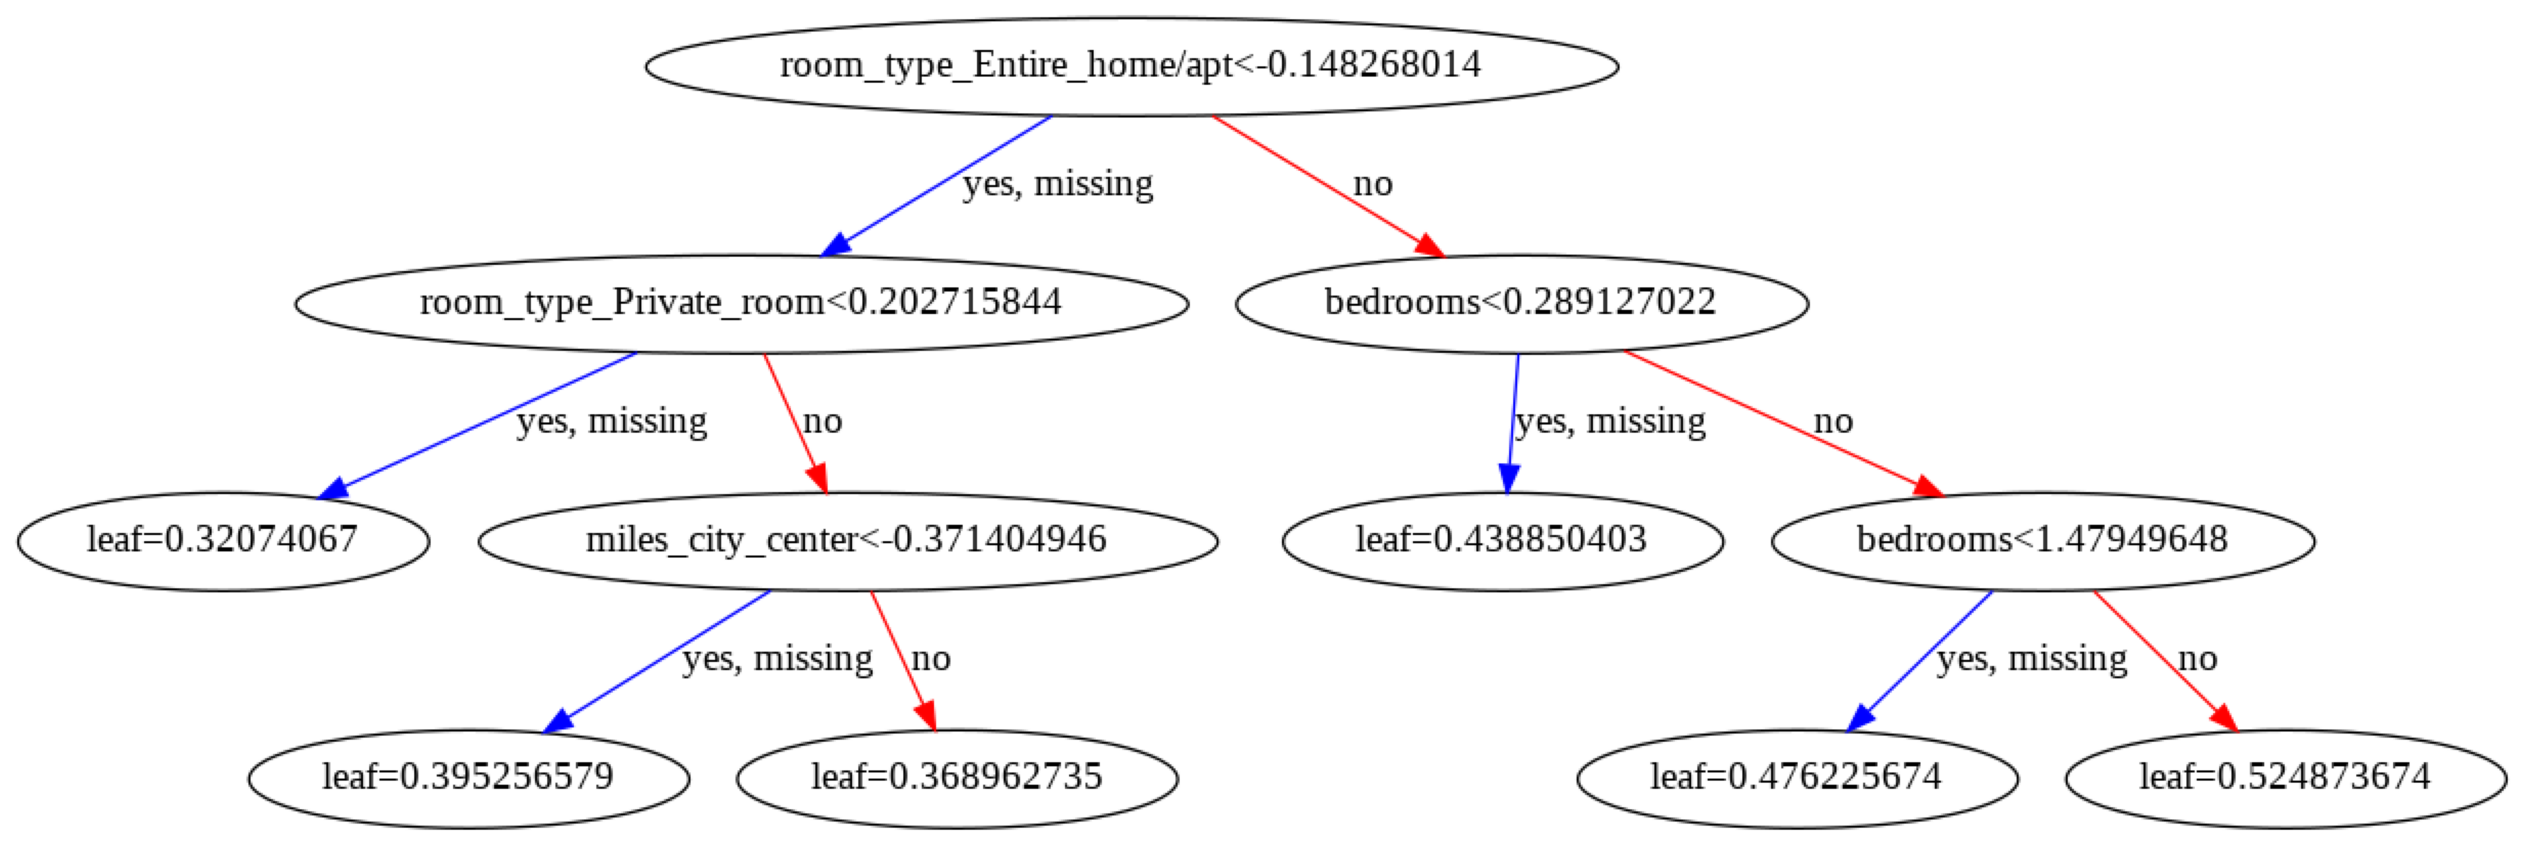

In [0]:
fig, ax = plt.subplots(1,1,figsize=(45, 45))
xg_reg = xgb.train(params=params, dtrain=xgtest, num_boost_round=10)
xgb.plot_tree(xg_reg,num_trees=0, ax=ax)
plt.show()



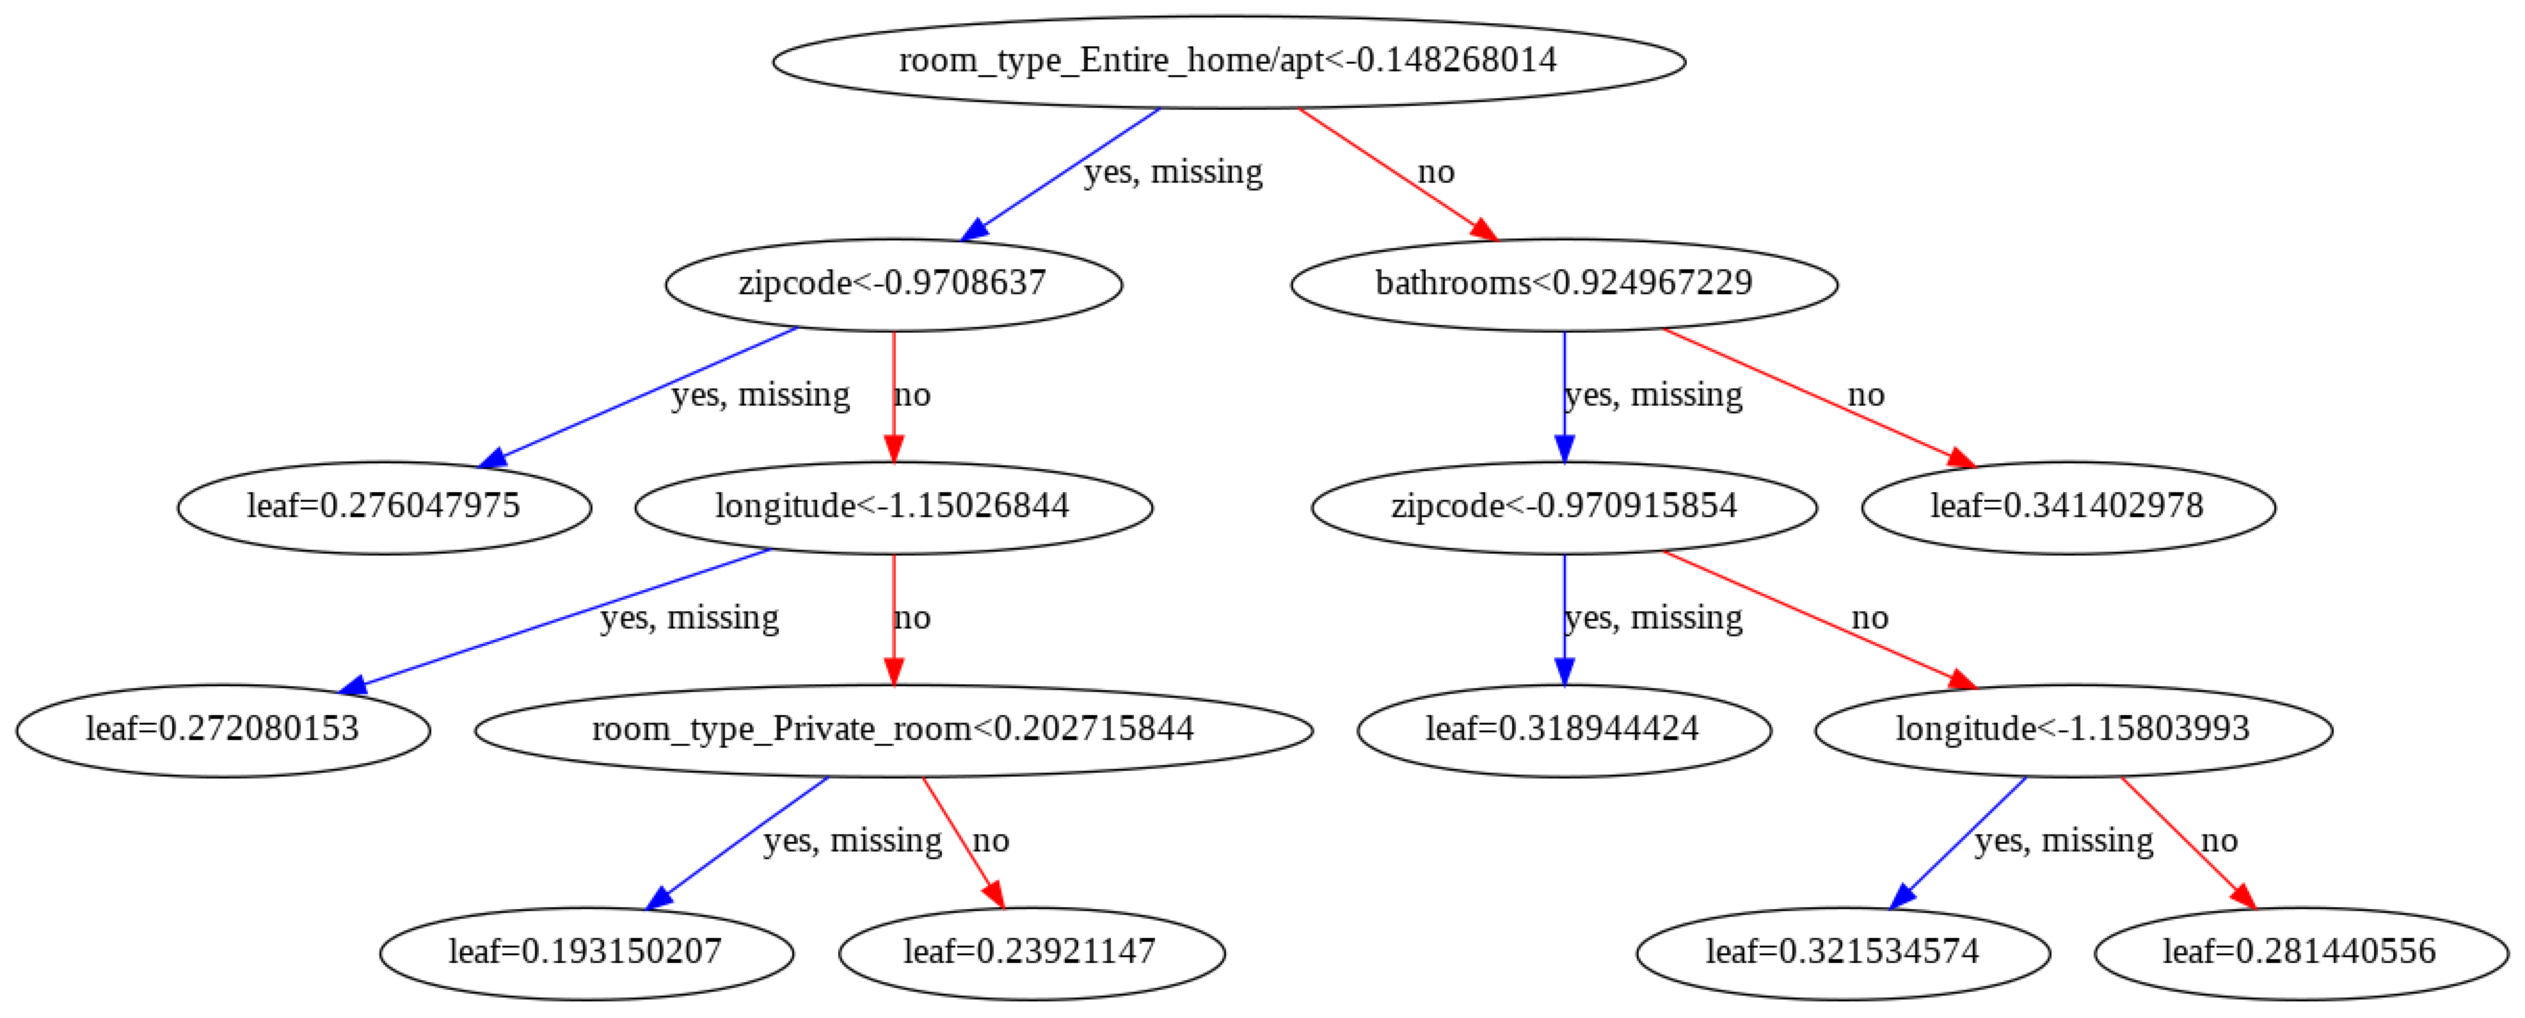

In [0]:
# Plot the fifth tree
fig, ax = plt.subplots(1,1,figsize=(45, 45))
xgb.plot_tree(xg_reg, num_trees=4, ax=ax)
plt.show()

### Plotting feature importance

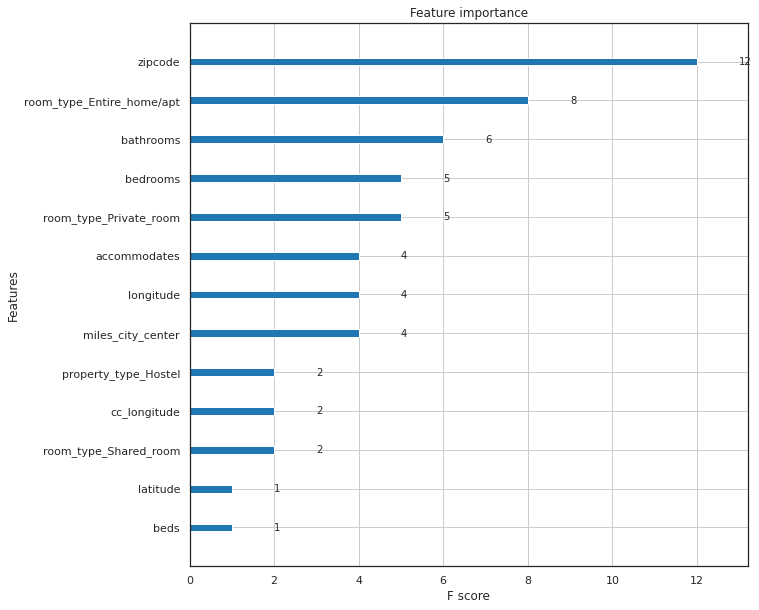

In [0]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(xg_reg, max_num_features=20, ax=ax)
plt.show()

### Plots

[Text(0, 0.5, 'Residual / Variance / Error'), Text(0.5, 0, 'Actual Prices')]

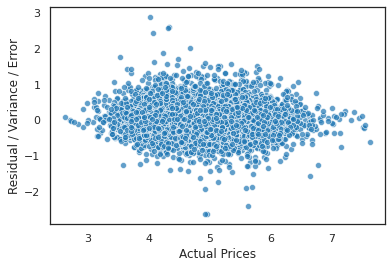

In [0]:
y_scatter  = y_test - preds
ax = sns.scatterplot(preds, y_scatter, alpha=0.7)
ax.set(xlabel='Actual Prices', ylabel='Residual / Variance / Error')

#### Examining Predicted vs. Residual (“The Residual Plot”)

Residual = Observed – Predicted

In the above plot, positive values for the residual (on the y-axis) mean the prediction was too low, and negative values mean the prediction was too high; 0 means the guess was exactly correct.

We can tell that XGB model is correctly predicting because of the following characteristics of the residual plot:


1.   It is symmetrically distributed, tending to cluster towards the middle of the plot
2.   It clustered around the lower single digits of the y-axis

In general, there aren’t any clear patterns.





[Text(0, 0.5, 'Predicted Prices'), Text(0.5, 0, 'Actual Prices')]

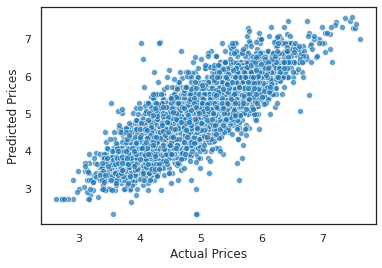

In [0]:
ax = sns.scatterplot(preds, y_test, alpha=0.7)
ax.set(xlabel='Actual Prices', ylabel='Predicted Prices')

In [0]:
#### pt summary ###
pt = PrettyTable()
pt.field_names = ["model", "RMSE", "RMSE 95% CI", 'Cross_Val_Mean']
for i in range(0, len(model_name)):
    pt.add_row([model_name[i], np.round(RMSE[i], 3), np.round(CI[i], 3), np.round(cross_val_mean[i], 3)])
print(pt)

+-------------------+-------+---------------+----------------+
|       model       |  RMSE |  RMSE 95% CI  | Cross_Val_Mean |
+-------------------+-------+---------------+----------------+
|  Sequential Keras | 0.364 |       0       |     0.368      |
| Linear Regression | 0.389 | [0.382 0.396] | 1714508025.803 |
|  Ridge Regression | 0.392 | [0.385 0.399] |     0.409      |
|  Lasso Regression | 0.409 | [0.402 0.416] |     0.671      |
|     Linear SVM    | 1.395 | [1.385 1.405] |     1.836      |
|  xgboost-baseline |  0.35 | [0.513 0.796] |       0        |
| xgboost-optimized | 0.343 | [0.489 0.774] |       0        |
+-------------------+-------+---------------+----------------+
